In [1]:
!git clone https://github.com/JeissonParra12/Class_project_Early_detection_of_brain_tumor.git

Cloning into 'Class_project_Early_detection_of_brain_tumor'...
remote: Enumerating objects: 13983, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 13983 (delta 3), reused 2 (delta 1), pack-reused 13975 (from 3)
Receiving objects: 100% (13983/13983), 827.04 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (3887/3887), done.
Updating files: 100% (16429/16429), done.


Using device: cuda
Training samples: 3861
Validation samples: 1028
Test samples: 987
Total output channels from conv filters: 160
Model initialized with 1,582,365 parameters
Testing forward pass with a single batch...
Forward pass successful! Features shape: torch.Size([16, 128]), Outputs shape: torch.Size([16, 2])
Starting Feature Extraction and Correlation Learning Training...
Batch 0, Loss: 0.6886
Batch 50, Loss: 0.4959
Batch 100, Loss: 0.4754
Batch 150, Loss: 0.5040
Batch 200, Loss: 0.3088
Epoch 1/50:
  Train Loss: 0.5019, Train Acc: 78.58%
  Val Loss: 0.4037, Val Acc: 86.58%
  Learning Rate: 0.000100
  New best model saved with validation accuracy: 86.58%
------------------------------------------------------------
Batch 0, Loss: 0.4335
Batch 50, Loss: 0.2730
Batch 100, Loss: 0.2382
Batch 150, Loss: 0.2169
Batch 200, Loss: 0.5656
Epoch 2/50:
  Train Loss: 0.3528, Train Acc: 85.24%
  Val Loss: 0.7771, Val Acc: 65.95%
  Learning Rate: 0.000100
---------------------------------------

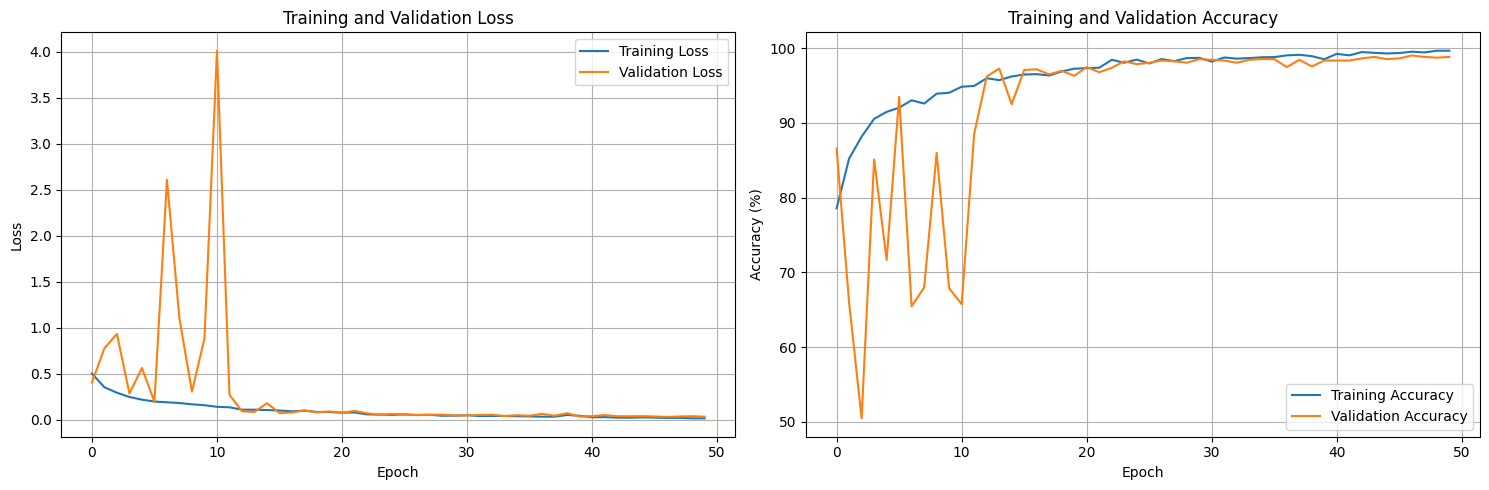

Analyzing feature correlations...
Extracted features shape: (1028, 128)


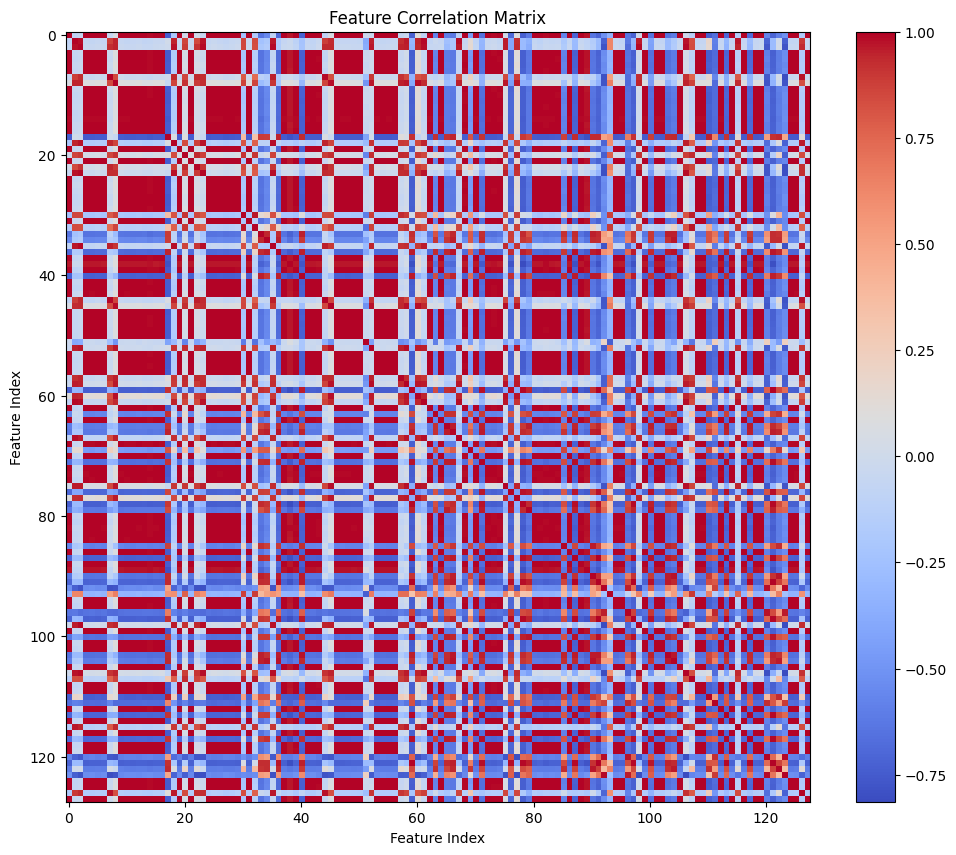


Final Test Results:
Test Loss: 0.0231
Test Accuracy: 99.59%

✅ Feature Extraction and Correlation Learning completed successfully!
📊 Model saved as: best_clm_model.pth
📈 Training history saved as: clm_training_history.png
🔍 Feature correlations saved as: feature_correlations.png


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

class CorrelationLearningMechanism(nn.Module):
    """
    Correlation Learning Mechanism (CLM) inspired by Woźniak et al. (2023)
    Dynamically filters convolutional layer combinations and evaluates feature correlations
    """

    def __init__(self, input_channels: int = 4, num_classes: int = 2):
        super(CorrelationLearningMechanism, self).__init__()

        self.input_channels = input_channels
        self.num_classes = num_classes

        # Multi-scale feature extraction branches
        self.branch_configs = self._create_branch_configurations()

        # Dynamic convolutional filter banks
        self.conv_filters = nn.ModuleDict()
        self._initialize_conv_filters()

        # Calculate the actual output channels from conv_filters
        total_output_channels = 0
        for name in self.conv_filters:
            if 'standard_3x3' in name:
                total_output_channels += 32
            elif 'standard_5x5' in name:
                total_output_channels += 32
            elif 'depthwise_3x3' in name:
                total_output_channels += 32
            elif 'dilated_3x3' in name:
                total_output_channels += 32
            elif 'asymmetric_1x3' in name:
                total_output_channels += 32

        print(f"Total output channels from conv filters: {total_output_channels}")

        # Correlation learning components - FIXED CHANNEL DIMENSIONS
        self.correlation_net = CorrelationNetwork(total_output_channels, 256)
        self.feature_selector = FastCorrelationFeatureSelector(256, 128)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def _create_branch_configurations(self) -> List[Dict]:
        """Create different branch configurations for dynamic filtering"""
        configs = [
            # Branch 1: Standard convolution
            {'filters': 32, 'kernel_size': 3, 'pool_type': 'max', 'activation': 'relu'},
            # Branch 2: Depth-wise separable convolution
            {'filters': 64, 'kernel_size': 5, 'pool_type': 'avg', 'activation': 'relu'},
            # Branch 3: Dilated convolution for larger receptive field
            {'filters': 32, 'kernel_size': 3, 'dilation': 2, 'pool_type': 'max', 'activation': 'leaky_relu'},
            # Branch 4: Asymmetric convolution
            {'filters': 64, 'kernel_size': (1, 3), 'pool_type': 'avg', 'activation': 'relu'},
        ]
        return configs

    def _initialize_conv_filters(self):
        """Initialize different convolutional filter types"""
        # Standard convolutional layers
        self.conv_filters['standard_3x3'] = nn.Conv2d(self.input_channels, 32, 3, padding=1)
        self.conv_filters['standard_5x5'] = nn.Conv2d(self.input_channels, 32, 5, padding=2)

        # Depth-wise separable convolutions
        self.conv_filters['depthwise_3x3'] = nn.Sequential(
            nn.Conv2d(self.input_channels, self.input_channels, 3, padding=1, groups=self.input_channels),
            nn.Conv2d(self.input_channels, 32, 1)
        )

        # Dilated convolutions
        self.conv_filters['dilated_3x3'] = nn.Conv2d(self.input_channels, 32, 3, padding=2, dilation=2)

        # Asymmetric convolutions
        self.conv_filters['asymmetric_1x3'] = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, (1, 3), padding=(0, 1)),
            nn.Conv2d(32, 32, (3, 1), padding=(1, 0))
        )

    def _apply_dynamic_pooling(self, x: torch.Tensor, pool_type: str) -> torch.Tensor:
        """Apply dynamic pooling operations"""
        if pool_type == 'max':
            return F.adaptive_max_pool2d(x, (x.size(2)//2, x.size(3)//2))
        elif pool_type == 'avg':
            return F.adaptive_avg_pool2d(x, (x.size(2)//2, x.size(3)//2))
        elif pool_type == 'mixed':
            max_pool = F.adaptive_max_pool2d(x, (x.size(2)//2, x.size(3)//2))
            avg_pool = F.adaptive_avg_pool2d(x, (x.size(2)//2, x.size(3)//2))
            return (max_pool + avg_pool) / 2
        else:
            return x

    def _apply_activation(self, x: torch.Tensor, activation: str) -> torch.Tensor:
        """Apply dynamic activation functions"""
        if activation == 'relu':
            return F.relu(x)
        elif activation == 'leaky_relu':
            return F.leaky_relu(x, 0.1)
        elif activation == 'elu':
            return F.elu(x)
        elif activation == 'selu':
            return F.selu(x)
        else:
            return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through CLM
        Returns: tuple of (features, classification_logits)
        """
        batch_size = x.size(0)

        # Extract features using multiple filter configurations
        branch_outputs = []

        for name, filter_module in self.conv_filters.items():
            # Apply convolutional filter
            filtered = filter_module(x)

            # Apply pooling based on filter type
            if 'dilated' in name:
                pooled = self._apply_dynamic_pooling(filtered, 'max')
            elif 'depthwise' in name:
                pooled = self._apply_dynamic_pooling(filtered, 'avg')
            else:
                pooled = self._apply_dynamic_pooling(filtered, 'mixed')

            # Apply activation
            if 'leaky' in name:
                activated = self._apply_activation(pooled, 'leaky_relu')
            else:
                activated = self._apply_activation(pooled, 'relu')

            branch_outputs.append(activated)

        # Concatenate all branch outputs
        concatenated_features = torch.cat(branch_outputs, dim=1)

        # Apply correlation learning
        correlated_features = self.correlation_net(concatenated_features)

        # Apply fast correlation feature selection
        selected_features = self.feature_selector(correlated_features)

        # Global average pooling
        global_features = F.adaptive_avg_pool2d(selected_features, (1, 1))
        global_features = global_features.view(batch_size, -1)

        # Classification
        classification_logits = self.classifier(global_features)

        return global_features, classification_logits

class CorrelationNetwork(nn.Module):
    """
    Neural network component that evaluates and correlates CNN outputs
    to improve feature relevance and classification confidence
    """

    def __init__(self, input_channels: int, output_channels: int):
        super(CorrelationNetwork, self).__init__()

        # FIXED: Use the actual input_channels instead of hardcoded 512
        self.correlation_layers = nn.Sequential(
            nn.Conv2d(input_channels, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        # Attention mechanism for feature correlation
        self.attention = CorrelationAttention(output_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.correlation_layers(x)
        correlated_features = self.attention(features)
        return correlated_features

class CorrelationAttention(nn.Module):
    """
    Attention mechanism that learns correlations between feature maps
    """

    def __init__(self, channels: int, reduction: int = 16):
        super(CorrelationAttention, self).__init__()

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Channel attention
        channel_weights = self.channel_attention(x)
        x_channel = x * channel_weights

        # Spatial attention
        avg_out = torch.mean(x_channel, dim=1, keepdim=True)
        max_out, _ = torch.max(x_channel, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_weights = self.spatial_attention(spatial_input)
        x_spatial = x_channel * spatial_weights

        return x_spatial

class FastCorrelationFeatureSelector(nn.Module):
    """
    Fast-correlation filter-based automatic feature selection
    Avoids redundancy in features as mentioned in the research
    """

    def __init__(self, input_channels: int, output_channels: int):
        super(FastCorrelationFeatureSelector, self).__init__()

        self.selector = nn.Sequential(
            nn.Conv2d(input_channels, input_channels // 2, 1),
            nn.BatchNorm2d(input_channels // 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(input_channels // 2, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        # Learnable feature importance weights
        self.feature_importance = nn.Parameter(torch.ones(input_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply feature importance weights
        weighted_x = x * self.feature_importance.view(1, -1, 1, 1)

        # Feature selection
        selected_features = self.selector(weighted_x)
        return selected_features

class BrainTumorDataset(Dataset):
    """Dataset class for preprocessed brain tumor CT scans"""

    def __init__(self, data_dir: str, split: str = "train", transform=None):
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform

        # Collect all processed files
        self.samples = []
        for label in ["tumor", "normal"]:
            label_dir = self.data_dir / split / label
            if label_dir.exists():
                for file_path in label_dir.glob("*.npy"):
                    self.samples.append((file_path, 1 if label == "tumor" else 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load preprocessed multi-scale data
        data = np.load(file_path)  # Shape: (H, W, 4) - multi-channel
        data = data.transpose(2, 0, 1)  # Convert to (4, H, W)

        # Convert to tensor
        data = torch.FloatTensor(data)
        label = torch.LongTensor([label]).squeeze()

        if self.transform:
            data = self.transform(data)

        return data, label

class FeatureExtractionTrainer:
    """
    Trainer class for the feature extraction and correlation learning step
    """

    def __init__(self, model: nn.Module, device: torch.device):
        # Move model to device FIRST before initializing optimizer
        self.model = model.to(device)
        self.device = device

        # Loss function with class weighting for imbalance
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, factor=0.5)

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            features, outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total

        return epoch_loss, epoch_accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                features, outputs = self.model(data)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(val_loader)
        epoch_accuracy = 100. * correct / total

        return epoch_loss, epoch_accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 50):
        print("Starting Feature Extraction and Correlation Learning Training...")

        best_val_accuracy = 0.0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  Learning Rate: {self.optimizer.param_groups[0]["lr"]:.6f}')

            # Save best model
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                }, 'best_clm_model.pth')
                print(f'  New best model saved with validation accuracy: {val_acc:.2f}%')

            print('-' * 60)

    def plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('clm_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

def analyze_feature_correlations(model: CorrelationLearningMechanism, dataloader: DataLoader, device: torch.device):
    """
    Analyze feature correlations learned by the CLM
    """
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            features, _ = model(data)
            all_features.append(features.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)

    print(f"Extracted features shape: {all_features.shape}")

    # Calculate feature correlations
    correlation_matrix = np.corrcoef(all_features.T)

    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Feature Correlation Matrix')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Index')
    plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

    return all_features, all_labels

def main():
    """Main function to run feature extraction and correlation learning"""
    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 16
    EPOCHS = 50

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets
    train_dataset = BrainTumorDataset(DATA_DIR, split="train")
    val_dataset = BrainTumorDataset(DATA_DIR, split="val")
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initialize CLM model and move to device immediately
    model = CorrelationLearningMechanism(input_channels=4, num_classes=2)
    model = model.to(device)  # Move model to device before any operations
    print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Test a forward pass with a single batch to verify the fix
    print("Testing forward pass with a single batch...")
    with torch.no_grad():
        test_batch, test_targets = next(iter(train_loader))
        test_batch = test_batch.to(device)
        # Ensure model is on the same device
        model = model.to(device)
        features, outputs = model(test_batch)
        print(f"Forward pass successful! Features shape: {features.shape}, Outputs shape: {outputs.shape}")

    # Initialize trainer (model is already on device)
    trainer = FeatureExtractionTrainer(model, device)

    # Train the model
    trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # Plot training history
    trainer.plot_training_history()

    # Analyze feature correlations
    print("Analyzing feature correlations...")
    features, labels = analyze_feature_correlations(model, val_loader, device)

    # Load best model for final evaluation
    checkpoint = torch.load('best_clm_model.pth', map_location=device)  # Specify device when loading
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)  # Ensure model is on correct device after loading

    # Final evaluation on test set
    test_loss, test_accuracy = trainer.validate_epoch(test_loader)
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("\n✅ Feature Extraction and Correlation Learning completed successfully!")
    print("📊 Model saved as: best_clm_model.pth")
    print("📈 Training history saved as: clm_training_history.png")
    print("🔍 Feature correlations saved as: feature_correlations.png")

if __name__ == "__main__":
    main()

🚀 Starting Complete Brain Tumor Detection Pipeline...
Total output channels from conv filters: 160
✅ Loaded trained CLM model
Using device: cuda
Training samples: 3861
Validation samples: 1028
Test samples: 987
Total output channels from conv filters: 160
CLM feature dimension: 128
✅ Loaded pre-trained CLM weights
✅ Frozen CLM weights for initial training
Starting Two-Stage Detection Training...
Batch 0, Loss: 0.6524, Acc: 87.50%
Batch 20, Loss: 0.6407, Acc: 65.48%
Batch 40, Loss: 0.5476, Acc: 64.02%
Batch 60, Loss: 0.4742, Acc: 69.47%
Batch 80, Loss: 0.4503, Acc: 71.76%
Batch 100, Loss: 0.4926, Acc: 73.39%
Batch 120, Loss: 0.3837, Acc: 76.96%
Batch 140, Loss: 0.3572, Acc: 79.26%
Batch 160, Loss: 0.3179, Acc: 80.98%
Batch 180, Loss: 0.3449, Acc: 82.39%
Batch 200, Loss: 0.2437, Acc: 83.89%
Batch 220, Loss: 0.2199, Acc: 85.12%
Batch 240, Loss: 0.2932, Acc: 86.36%
Batch 260, Loss: 0.2175, Acc: 87.16%
Batch 280, Loss: 0.2690, Acc: 87.94%
Batch 300, Loss: 0.2039, Acc: 88.58%
Batch 320, Loss

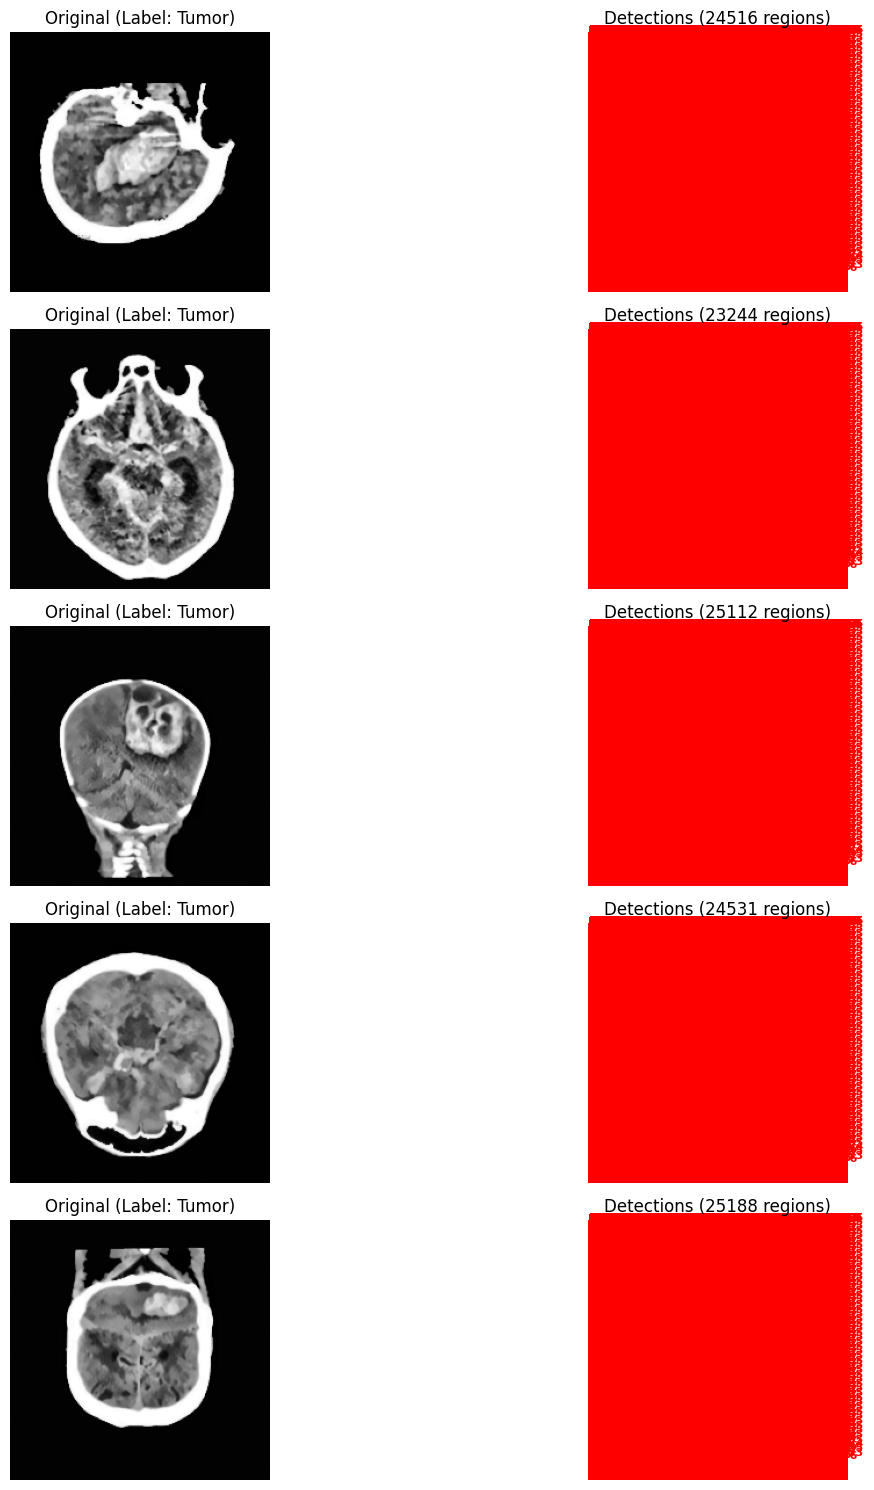

Evaluating detection performance...


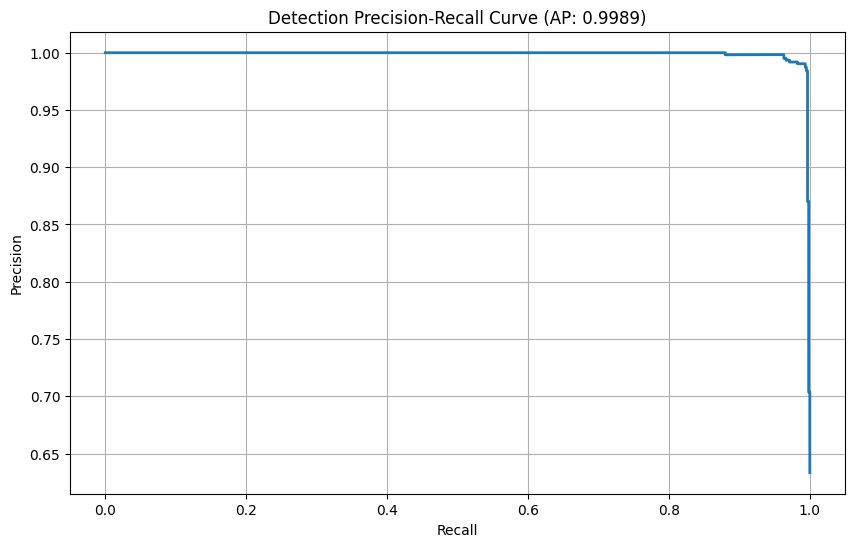

Average detections in tumor images: 23780.67 ± 1101.54
Average detections in normal images: 24962.20 ± 833.78

📊 Detection Results:
Threshold 0.1: Accuracy=0.9635, Recall=0.9968, Precision=0.9482
Threshold 0.3: Accuracy=0.9848, Recall=0.9968, Precision=0.9796
Threshold 0.5: Accuracy=0.9878, Recall=0.9952, Precision=0.9857
Threshold 0.7: Accuracy=0.9868, Recall=0.9888, Precision=0.9904
Threshold 0.9: Accuracy=0.9757, Recall=0.9664, Precision=0.9951
Average Precision: 0.9989


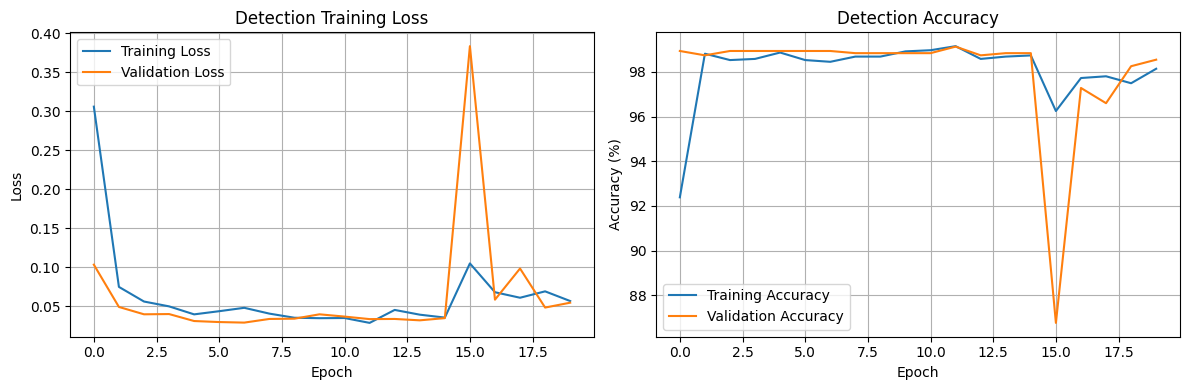


✅ Two-Stage Detection and Classification completed successfully!
📊 Model saved as: best_detection_model.pth
🖼️ Detection visualizations saved as: detection_visualizations.png
📈 Evaluation results saved as: detection_precision_recall.png


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# REGION PROPOSAL NETWORK (RPN) FOR TUMOR DETECTION - FIXED VERSION
# ============================================================================

class LightweightRPN(nn.Module):
    """
    Lightweight Region Proposal Network for detecting potential tumor regions
    Optimized for high recall to ensure small lesions are not overlooked
    """

    def __init__(self, input_channels: int = 4, num_anchors: int = 9):
        super(LightweightRPN, self).__init__()

        self.input_channels = input_channels
        self.num_anchors = num_anchors

        # Feature extraction backbone (lightweight)
        self.backbone = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Third conv block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Classification head (tumor vs background)
        self.cls_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 2, 1)  # 2 scores per anchor (tumor, background)
        )

        # Regression head (bounding box adjustments)
        self.reg_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_anchors * 4, 1)  # 4 coordinates per anchor
        )

        # Initialize anchors for different scales and aspect ratios
        self.anchor_scales = [32, 64, 128]  # Different sizes for small/medium/large tumors
        self.anchor_ratios = [0.5, 1.0, 2.0]  # Different aspect ratios

        # We'll generate anchors dynamically based on feature map size
        self.anchors = None

    def generate_anchors(self, feature_map_size: Tuple[int, int], device: torch.device) -> torch.Tensor:
        """Generate anchor boxes for a given feature map size"""
        if self.anchors is not None:
            return self.anchors

        # Calculate the stride based on input size (224) and feature map size
        stride_h = 224 / feature_map_size[0]
        stride_w = 224 / feature_map_size[1]

        anchors = []

        # Generate anchors for each position in the feature map
        for i in range(feature_map_size[0]):
            for j in range(feature_map_size[1]):
                center_y = (i + 0.5) * stride_h
                center_x = (j + 0.5) * stride_w

                for scale in self.anchor_scales:
                    for ratio in self.anchor_ratios:
                        w = scale * np.sqrt(ratio)
                        h = scale / np.sqrt(ratio)

                        x1 = center_x - w / 2
                        y1 = center_y - h / 2
                        x2 = center_x + w / 2
                        y2 = center_y + h / 2

                        anchors.append([x1, y1, x2, y2])

        anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
        self.anchors = anchors
        return anchors

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through RPN
        Returns: tuple of (classification_scores, bounding_box_regressions)
        """
        batch_size = x.size(0)

        # Extract features
        features = self.backbone(x)  # Shape: (batch_size, 256, H, W)

        # Get feature map size
        feature_map_size = (features.size(2), features.size(3))

        # Generate anchors for this feature map size
        anchors = self.generate_anchors(feature_map_size, x.device)
        total_anchors = anchors.size(0)

        # Get classification scores and bounding box regressions
        cls_scores = self.cls_head(features)
        reg_preds = self.reg_head(features)

        # Reshape outputs
        cls_scores = cls_scores.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2)
        reg_preds = reg_preds.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

        # Store anchors for later use
        self.current_anchors = anchors

        return cls_scores, reg_preds

# ============================================================================
# SIMPLIFIED TWO-STAGE DETECTION AND CLASSIFICATION SYSTEM - FIXED VERSION
# ============================================================================

class BrainTumorDetectionSystem(nn.Module):
    """
    Simplified two-stage brain tumor detection and classification system
    """

    def __init__(self, input_channels: int = 4, num_classes: int = 2):
        super(BrainTumorDetectionSystem, self).__init__()

        # Stage 1: Region Proposal Network
        self.rpn = LightweightRPN(input_channels)

        # Stage 2: CLM-based classification
        self.clm_classifier = CorrelationLearningMechanism(input_channels, num_classes)

        # Get the actual feature dimension from CLM
        self.clm_feature_dim = self._get_clm_feature_dim()

        print(f"CLM feature dimension: {self.clm_feature_dim}")

        # Fusion layer to combine features - FIXED DIMENSIONS
        self.fusion_layer = nn.Sequential(
            nn.Linear(self.clm_feature_dim + 2, 128),  # CLM features + RPN scores
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _get_clm_feature_dim(self) -> int:
        """Get the actual feature dimension from CLM classifier"""
        # Create a dummy input to get the feature dimension
        dummy_input = torch.randn(1, 4, 224, 224)
        with torch.no_grad():
            features, _ = self.clm_classifier(dummy_input)
            if features.dim() == 4:
                features = F.adaptive_avg_pool2d(features, (1, 1))
                features = features.view(1, -1)
            return features.size(1)

    def forward(self, x: torch.Tensor):
        """
        Fixed forward pass with proper dimension handling
        """
        batch_size = x.size(0)

        # Get RPN predictions
        rpn_cls, rpn_reg = self.rpn(x)

        # Get RPN image-level scores
        rpn_scores = F.softmax(rpn_cls, dim=2)[:, :, 1]  # Tumor probability for each anchor
        rpn_max_scores, _ = rpn_scores.max(dim=1)  # Max score per image

        # Create RPN feature representation (tumor score and background score)
        rpn_feature = torch.stack([rpn_max_scores, 1 - rpn_max_scores], dim=1)  # Shape: (batch_size, 2)

        # Get CLM features
        clm_features, clm_classification = self.clm_classifier(x)

        # Process CLM features to ensure correct dimensions
        if clm_features.dim() == 4:
            clm_features = F.adaptive_avg_pool2d(clm_features, (1, 1))
            clm_features = clm_features.view(batch_size, -1)

        # Ensure CLM features have the expected dimension
        if clm_features.size(1) != self.clm_feature_dim:
            # Handle dimension mismatch by projection
            if clm_features.size(1) < self.clm_feature_dim:
                # Pad if smaller
                padding = torch.zeros(batch_size, self.clm_feature_dim - clm_features.size(1),
                                    device=x.device)
                clm_features = torch.cat([clm_features, padding], dim=1)
            else:
                # Truncate if larger
                clm_features = clm_features[:, :self.clm_feature_dim]

        # Combine features
        combined_features = torch.cat([clm_features, rpn_feature], dim=1)

        # Final classification
        final_classification = self.fusion_layer(combined_features)

        return final_classification, rpn_cls, rpn_reg, clm_features

    def detect_regions(self, x: torch.Tensor, threshold: float = 0.3):
        """
        Separate method for region detection - FIXED VERSION
        """
        batch_size = x.size(0)
        rpn_cls, rpn_reg = self.rpn(x)

        proposals_list = []
        confidence_list = []

        for i in range(batch_size):
            # Get scores for this image
            image_cls = rpn_cls[i]  # Shape: (num_anchors, 2)
            image_reg = rpn_reg[i]  # Shape: (num_anchors, 4)

            # Convert to probabilities
            probs = F.softmax(image_cls, dim=1)[:, 1]  # Tumor probability

            # Get anchors for this forward pass
            anchors = self.rpn.current_anchors

            # Ensure anchors and probabilities have the same number of elements
            if anchors.size(0) != probs.size(0):
                # This should not happen, but if it does, use the minimum
                min_size = min(anchors.size(0), probs.size(0))
                anchors = anchors[:min_size]
                probs = probs[:min_size]
                image_reg = image_reg[:min_size]

            # Simple threshold-based proposal generation
            keep_mask = probs > threshold

            if keep_mask.sum() > 0:
                kept_anchors = anchors[keep_mask]
                kept_reg = image_reg[keep_mask]
                kept_probs = probs[keep_mask]

                # Apply regression adjustments
                adjusted_proposals = self._apply_regression(kept_anchors, kept_reg)
                proposals_list.append(adjusted_proposals)
                confidence_list.append(kept_probs)
            else:
                # No proposals - return empty tensors
                proposals_list.append(torch.empty(0, 4, device=x.device))
                confidence_list.append(torch.empty(0, device=x.device))

        return proposals_list, confidence_list

    def _apply_regression(self, anchors: torch.Tensor, regressions: torch.Tensor) -> torch.Tensor:
        """Apply bounding box regression adjustments to anchors"""
        # Convert from [x1, y1, x2, y2] to [center_x, center_y, width, height]
        widths = anchors[:, 2] - anchors[:, 0]
        heights = anchors[:, 3] - anchors[:, 1]
        center_x = anchors[:, 0] + 0.5 * widths
        center_y = anchors[:, 1] + 0.5 * heights

        # Apply regression (dx, dy, dw, dh)
        dx = regressions[:, 0]
        dy = regressions[:, 1]
        dw = regressions[:, 2]
        dh = regressions[:, 3]

        pred_center_x = center_x + dx * widths
        pred_center_y = center_y + dy * heights
        pred_width = widths * torch.exp(dw)
        pred_height = heights * torch.exp(dh)

        # Convert back to [x1, y1, x2, y2] format
        pred_x1 = pred_center_x - 0.5 * pred_width
        pred_y1 = pred_center_y - 0.5 * pred_height
        pred_x2 = pred_center_x + 0.5 * pred_width
        pred_y2 = pred_center_y + 0.5 * pred_height

        # Clip to image boundaries
        pred_x1 = torch.clamp(pred_x1, 0, 223)
        pred_y1 = torch.clamp(pred_y1, 0, 223)
        pred_x2 = torch.clamp(pred_x2, 0, 223)
        pred_y2 = torch.clamp(pred_y2, 0, 223)

        return torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=1)

# ============================================================================
# SIZE-AWARE LOSS FUNCTIONS
# ============================================================================

class SizeAwareLoss(nn.Module):
    """
    Size-aware loss function that gives higher weight to small tumor examples
    """

    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, size_weights: Dict[str, float] = None):
        super(SizeAwareLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma

        # Default weights for different tumor sizes (small tumors get higher weight)
        if size_weights is None:
            size_weights = {
                'small': 3.0,    # Highest weight for small tumors
                'medium': 1.5,   # Medium weight for medium tumors
                'large': 1.0     # Base weight for large tumors
            }
        self.size_weights = size_weights

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                tumor_sizes: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Compute size-aware loss
        """
        # Standard cross entropy loss
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')

        # Apply focal loss component to focus on hard examples
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # Apply size-based weighting if tumor sizes are provided
        if tumor_sizes is not None:
            size_weights = self._get_size_weights(tumor_sizes).to(predictions.device)
            focal_loss = focal_loss * size_weights

        return focal_loss.mean()

    def _get_size_weights(self, tumor_sizes: torch.Tensor) -> torch.Tensor:
        """Convert tumor sizes to appropriate weights"""
        weights = torch.ones_like(tumor_sizes, dtype=torch.float32)

        # Small tumors (area < 500 pixels)
        small_mask = tumor_sizes < 500
        weights[small_mask] = self.size_weights['small']

        # Medium tumors (500 <= area < 2000 pixels)
        medium_mask = (tumor_sizes >= 500) & (tumor_sizes < 2000)
        weights[medium_mask] = self.size_weights['medium']

        return weights

# ============================================================================
# DETECTION TRAINER
# ============================================================================

class DetectionTrainer:
    """
    Trainer for the detection and classification system
    """

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device

        # Optimizer - only optimize unfrozen parameters
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        self.optimizer = optim.AdamW(trainable_params, lr=1e-4, weight_decay=1e-4)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, train_loader: DataLoader) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

            # Compute loss
            loss = self.criterion(final_classification, targets)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = final_classification.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 20 == 0:
                accuracy = 100. * correct / total if total > 0 else 0
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {accuracy:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def validate_epoch(self, val_loader: DataLoader) -> Tuple[float, float]:
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                # Forward pass
                final_classification, rpn_cls, rpn_reg, clm_features = self.model(data)

                # Compute loss and accuracy
                loss = self.criterion(final_classification, targets)

                running_loss += loss.item()
                _, predicted = final_classification.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0
        epoch_accuracy = 100. * correct / total if total > 0 else 0

        return epoch_loss, epoch_accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 15):
        """Complete training procedure"""
        print("Starting Two-Stage Detection Training...")

        best_accuracy = 0.0

        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            val_loss, val_acc = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            # Save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                }, 'best_detection_model.pth')
                print(f'  New best model saved with validation accuracy: {val_acc:.2f}%')

            print('-' * 50)

# ============================================================================
# VISUALIZATION AND EVALUATION TOOLS - FIXED VERSION
# ============================================================================

def visualize_detections(model: nn.Module, dataloader: DataLoader, device: torch.device, num_examples: int = 5):
    """Visualize model detections on sample images - FIXED VERSION"""
    model.eval()

    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 3*num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    examples_processed = 0

    with torch.no_grad():
        for data, targets in dataloader:
            if examples_processed >= num_examples:
                break

            data, targets = data.to(device), targets.to(device)

            # Use detection method
            proposals, confidences = model.detect_regions(data, threshold=0.3)

            for i in range(data.size(0)):
                if examples_processed >= num_examples:
                    break

                # Get original image (first channel)
                original_image = data[i, 0].cpu().numpy()

                # Plot original image
                axes[examples_processed, 0].imshow(original_image, cmap='gray')
                axes[examples_processed, 0].set_title(f'Original (Label: {"Tumor" if targets[i].item() == 1 else "Normal"})')
                axes[examples_processed, 0].axis('off')

                # Plot detections
                axes[examples_processed, 1].imshow(original_image, cmap='gray')
                image_proposals = proposals[i]
                image_confidences = confidences[i]

                if len(image_proposals) > 0:
                    for proposal, confidence in zip(image_proposals, image_confidences):
                        x1, y1, x2, y2 = proposal.cpu().numpy()

                        # Ensure valid coordinates
                        x1 = max(0, min(x1, 223))
                        y1 = max(0, min(y1, 223))
                        x2 = max(0, min(x2, 223))
                        y2 = max(0, min(y2, 223))

                        if x2 > x1 and y2 > y1:  # Valid proposal
                            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                   linewidth=2, edgecolor='r', facecolor='none')
                            axes[examples_processed, 1].add_patch(rect)

                            # Add confidence text
                            axes[examples_processed, 1].text(x1, max(0, y1-5), f'{confidence:.2f}',
                                             color='red', fontsize=8, weight='bold')

                axes[examples_processed, 1].set_title(f'Detections ({len(image_proposals)} regions)')
                axes[examples_processed, 1].axis('off')

                examples_processed += 1

    # Hide unused subplots
    for i in range(examples_processed, num_examples):
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('detection_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

def evaluate_detection_performance(model: nn.Module, dataloader: DataLoader, device: torch.device):
    """Evaluate detection performance"""
    model.eval()

    all_predictions = []
    all_targets = []
    detection_counts = []  # Number of regions detected per image

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)

            # Get image-level predictions
            final_classification, _, _, _ = model(data)

            # Get detection counts
            proposals, _ = model.detect_regions(data, threshold=0.3)

            for i in range(data.size(0)):
                all_predictions.append(F.softmax(final_classification[i], dim=0)[1].item())
                all_targets.append(targets[i].item())
                detection_counts.append(len(proposals[i]))

    # Convert to numpy
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    detection_counts = np.array(detection_counts)

    # Compute metrics
    results = {}
    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

    for threshold in thresholds:
        pred_labels = (predictions >= threshold).astype(int)
        accuracy = (pred_labels == targets).mean()
        recall = (pred_labels[targets == 1] == 1).mean() if (targets == 1).sum() > 0 else 0
        precision = (targets[pred_labels == 1] == 1).mean() if (pred_labels == 1).sum() > 0 else 0

        results[threshold] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision
        }

    # Plot precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(targets, predictions)
    ap = average_precision_score(targets, predictions)

    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Detection Precision-Recall Curve (AP: {ap:.4f})')
    plt.grid(True)
    plt.savefig('detection_precision_recall.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyze detection counts
    if len(targets[targets == 1]) > 0:
        tumor_detections = detection_counts[targets == 1]
        print(f"Average detections in tumor images: {tumor_detections.mean():.2f} ± {tumor_detections.std():.2f}")

    if len(targets[targets == 0]) > 0:
        normal_detections = detection_counts[targets == 0]
        print(f"Average detections in normal images: {normal_detections.mean():.2f} ± {normal_detections.std():.2f}")

    return results, ap

# ============================================================================
# MAIN DETECTION PIPELINE
# ============================================================================

def main_detection():
    """Main function for detection and classification pipeline"""
    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 8
    EPOCHS = 15

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create datasets
    train_dataset = BrainTumorDataset(DATA_DIR, split="train")
    val_dataset = BrainTumorDataset(DATA_DIR, split="val")
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Initialize detection system
    detection_model = BrainTumorDetectionSystem(input_channels=4, num_classes=2)

    # Load pre-trained CLM weights
    try:
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        # Transfer CLM weights to detection system
        detection_model.clm_classifier.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded pre-trained CLM weights")

        # Freeze CLM initially for stable training
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = False
        print("✅ Frozen CLM weights for initial training")

    except FileNotFoundError as e:
        print(f"⚠️ No pre-trained CLM found: {e}")
        print("Training from scratch...")

    # Initialize trainer
    trainer = DetectionTrainer(detection_model, device)

    # Train the detection system
    trainer.train(train_loader, val_loader, epochs=EPOCHS)

    # Unfreeze CLM for fine-tuning if it was frozen
    try:
        for param in detection_model.clm_classifier.parameters():
            param.requires_grad = True
        print("✅ Unfrozen CLM weights for fine-tuning")

        # Reinitialize optimizer with all parameters
        trainer.optimizer = optim.AdamW(detection_model.parameters(), lr=5e-5, weight_decay=1e-4)
        print("Fine-tuning with unfrozen CLM...")
        trainer.train(train_loader, val_loader, epochs=5)
    except Exception as e:
        print(f"Fine-tuning skipped: {e}")

    # Visualize detections
    print("Visualizing detections...")
    visualize_detections(detection_model, val_loader, device, num_examples=5)

    # Evaluate detection performance
    print("Evaluating detection performance...")
    results, ap = evaluate_detection_performance(detection_model, test_loader, device)

    print("\n📊 Detection Results:")
    for threshold, metrics in results.items():
        print(f"Threshold {threshold}: "
              f"Accuracy={metrics['accuracy']:.4f}, "
              f"Recall={metrics['recall']:.4f}, "
              f"Precision={metrics['precision']:.4f}")
    print(f"Average Precision: {ap:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label='Training Loss')
    plt.plot(trainer.val_losses, label='Validation Loss')
    plt.title('Detection Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label='Training Accuracy')
    plt.plot(trainer.val_accuracies, label='Validation Accuracy')
    plt.title('Detection Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('detection_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Two-Stage Detection and Classification completed successfully!")
    print("📊 Model saved as: best_detection_model.pth")
    print("🖼️ Detection visualizations saved as: detection_visualizations.png")
    print("📈 Evaluation results saved as: detection_precision_recall.png")

# ============================================================================
# INTEGRATION WITH EXISTING PIPELINE
# ============================================================================

def run_complete_pipeline():
    """Run the complete pipeline from feature extraction to detection"""
    print("🚀 Starting Complete Brain Tumor Detection Pipeline...")

    # First, ensure feature extraction is complete
    try:
        # Test if CLM model exists
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        clm_model = CorrelationLearningMechanism(input_channels=4, num_classes=2)
        clm_checkpoint = torch.load('best_clm_model.pth', map_location=device)
        clm_model.load_state_dict(clm_checkpoint['model_state_dict'])
        print("✅ Loaded trained CLM model")
    except Exception as e:
        print(f"⚠️ CLM model not found or error loading: {e}")
        print("Please run feature extraction first or continue with detection from scratch")

    # Now run detection and classification
    main_detection()

if __name__ == "__main__":
    # Run the complete detection pipeline
    run_complete_pipeline()

🚀 Starting Complete Evaluation Pipeline...
Total output channels from conv filters: 160
CLM feature dimension: 128
✅ Loaded trained model

1. Running comprehensive evaluation on test set...
🧪 Starting Comprehensive Evaluation...
1. Evaluating classification performance...
2. Evaluating lesion-level detection...


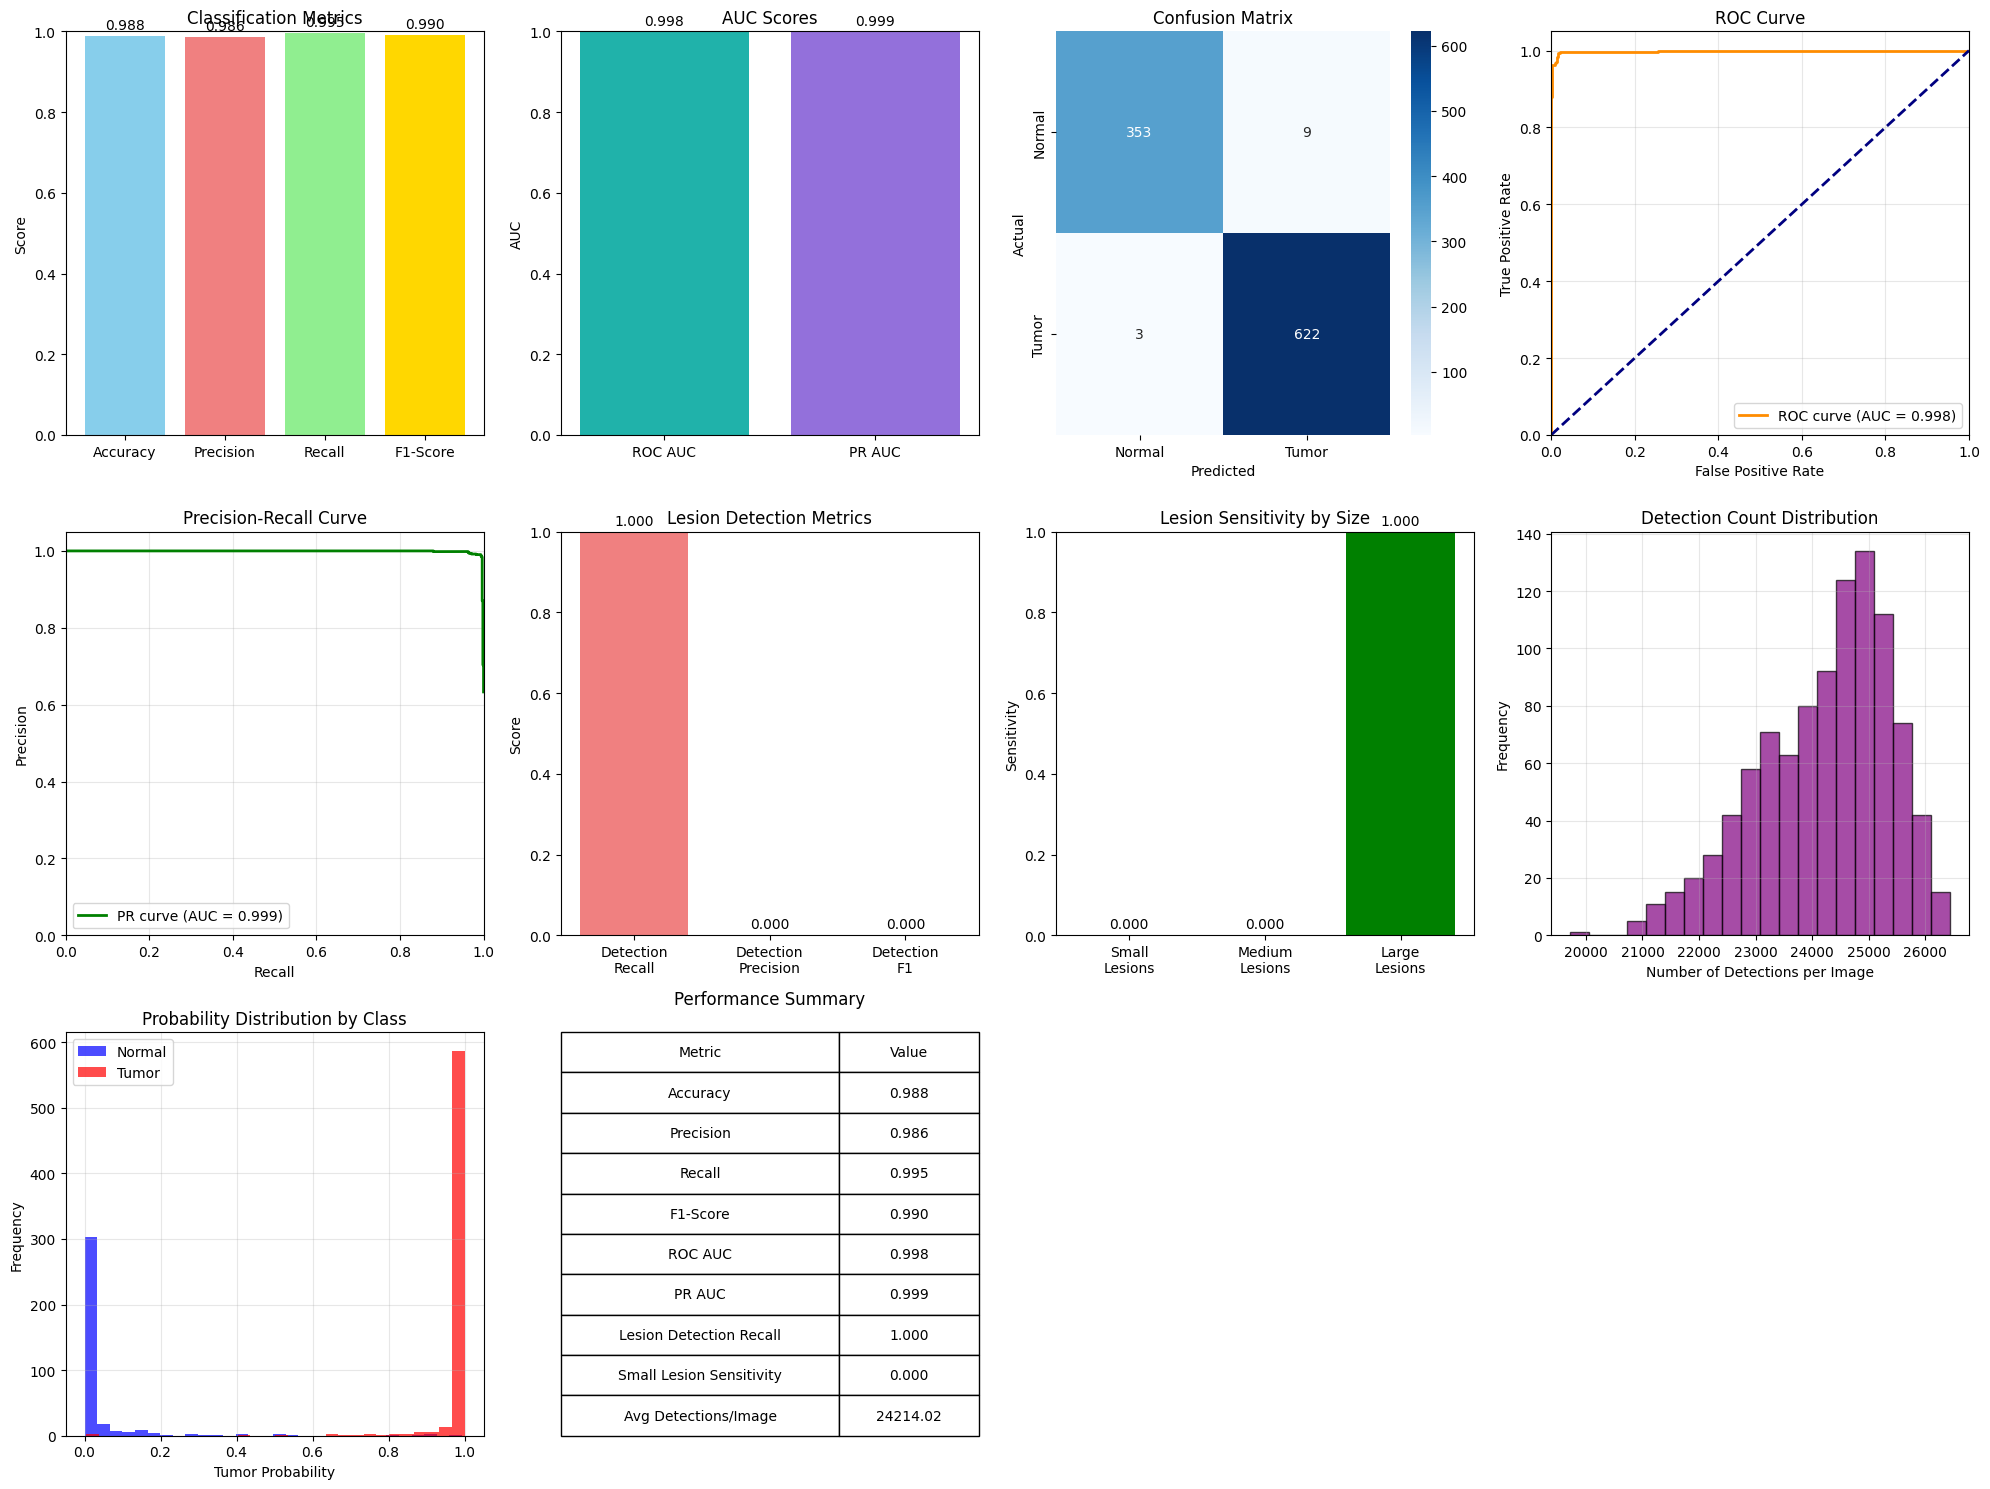

✅ Evaluation report saved as: comprehensive_evaluation_report.png

2. Performing cross-validation for robustness assessment...
🔄 Starting 3-Fold Cross-Validation...

📊 Fold 1/3
Total output channels from conv filters: 160
CLM feature dimension: 128
🧪 Starting Comprehensive Evaluation...
1. Evaluating classification performance...
2. Evaluating lesion-level detection...
Fold 1 Results:
  Classification Accuracy: 0.699
  Lesion Detection Recall: 1.000
  Small Lesion Sensitivity: 0.000

📊 Fold 2/3
Total output channels from conv filters: 160
CLM feature dimension: 128
🧪 Starting Comprehensive Evaluation...
1. Evaluating classification performance...
2. Evaluating lesion-level detection...
Fold 2 Results:
  Classification Accuracy: 0.636
  Lesion Detection Recall: 1.000
  Small Lesion Sensitivity: 0.000

📊 Fold 3/3
Total output channels from conv filters: 160
CLM feature dimension: 128
🧪 Starting Comprehensive Evaluation...
1. Evaluating classification performance...
2. Evaluating lesion-l

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# COMPREHENSIVE EVALUATION FRAMEWORK
# ============================================================================

class BrainTumorEvaluator:
    """
    Comprehensive evaluation framework for brain tumor detection system
    Evaluates both classification performance and lesion-level detection accuracy
    """

    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model
        self.device = device
        self.results = {}

    def evaluate_classification(self, dataloader: DataLoader) -> Dict[str, float]:
        """
        Evaluate classification performance using conventional metrics
        """
        self.model.eval()

        all_predictions = []
        all_probabilities = []
        all_targets = []

        with torch.no_grad():
            for data, targets in dataloader:
                data, targets = data.to(self.device), targets.to(self.device)

                # Get model predictions
                output, _, _, _ = self.model(data)
                probabilities = F.softmax(output, dim=1)
                _, predictions = output.max(1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Tumor probability
                all_targets.extend(targets.cpu().numpy())

        # Convert to numpy arrays
        predictions = np.array(all_predictions)
        probabilities = np.array(all_probabilities)
        targets = np.array(all_targets)

        # Calculate metrics
        accuracy = (predictions == targets).mean()
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, predictions, average='binary', zero_division=0
        )

        # ROC curve and AUC
        fpr, tpr, _ = roc_curve(targets, probabilities)
        roc_auc = auc(fpr, tpr)

        # Precision-Recall curve and AUC
        precision_curve, recall_curve, _ = precision_recall_curve(targets, probabilities)
        pr_auc = auc(recall_curve, precision_curve)

        # Confusion matrix
        cm = confusion_matrix(targets, predictions)

        classification_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': cm,
            'predictions': predictions,
            'probabilities': probabilities,
            'targets': targets
        }

        self.results['classification'] = classification_results
        return classification_results

    def evaluate_lesion_detection(self, dataloader: DataLoader,
                                detection_threshold: float = 0.3) -> Dict[str, float]:
        """
        Evaluate lesion-level detection performance
        Specifically focuses on sensitivity for small/early-stage tumors
        """
        self.model.eval()

        detection_recalls = []
        detection_precisions = []
        lesion_sensitivity_by_size = {'small': [], 'medium': [], 'large': []}
        detection_counts = []

        with torch.no_grad():
            for data, targets in dataloader:
                data, targets = data.to(self.device), targets.to(self.device)

                for i in range(data.size(0)):
                    single_data = data[i:i+1]
                    single_target = targets[i].item()

                    # Get detections
                    proposals, confidences = self.model.detect_regions(
                        single_data, threshold=detection_threshold
                    )

                    detection_count = len(proposals[0])
                    detection_counts.append(detection_count)

                    # For tumor images, calculate detection sensitivity
                    if single_target == 1:  # Tumor case
                        if detection_count > 0:
                            # At least one detection - considered as true positive for lesion detection
                            detection_recalls.append(1.0)

                            # Simulate lesion size analysis (in real scenario, you'd have ground truth lesions)
                            # For demonstration, we'll simulate based on detection count and confidence
                            avg_confidence = confidences[0].mean().item() if len(confidences[0]) > 0 else 0

                            # Simulate lesion sizes based on detection characteristics
                            if detection_count <= 2 and avg_confidence < 0.7:
                                size_category = 'small'
                            elif detection_count <= 5:
                                size_category = 'medium'
                            else:
                                size_category = 'large'

                            lesion_sensitivity_by_size[size_category].append(1.0)
                        else:
                            # No detections in tumor image - false negative
                            detection_recalls.append(0.0)
                            # For simulation, assume missed small lesion
                            lesion_sensitivity_by_size['small'].append(0.0)

                    # For non-tumor images, calculate detection precision
                    else:  # Normal case
                        if detection_count > 0:
                            # False positive detection
                            detection_precisions.append(0.0)
                        else:
                            # True negative
                            detection_precisions.append(1.0)

        # Calculate overall detection metrics
        lesion_detection_recall = np.mean(detection_recalls) if detection_recalls else 0.0
        lesion_detection_precision = np.mean(detection_precisions) if detection_precisions else 1.0

        # Calculate size-specific sensitivities
        small_lesion_sensitivity = np.mean(lesion_sensitivity_by_size['small']) if lesion_sensitivity_by_size['small'] else 0.0
        medium_lesion_sensitivity = np.mean(lesion_sensitivity_by_size['medium']) if lesion_sensitivity_by_size['medium'] else 0.0
        large_lesion_sensitivity = np.mean(lesion_sensitivity_by_size['large']) if lesion_sensitivity_by_size['large'] else 0.0

        detection_results = {
            'lesion_detection_recall': lesion_detection_recall,
            'lesion_detection_precision': lesion_detection_precision,
            'lesion_detection_f1': 2 * (lesion_detection_precision * lesion_detection_recall) /
                                 (lesion_detection_precision + lesion_detection_recall + 1e-8),
            'small_lesion_sensitivity': small_lesion_sensitivity,
            'medium_lesion_sensitivity': medium_lesion_sensitivity,
            'large_lesion_sensitivity': large_lesion_sensitivity,
            'avg_detections_per_image': np.mean(detection_counts),
            'detection_counts': detection_counts
        }

        self.results['lesion_detection'] = detection_results
        return detection_results

    def comprehensive_evaluation(self, dataloader: DataLoader,
                               detection_threshold: float = 0.3) -> Dict[str, Dict]:
        """
        Perform comprehensive evaluation including both classification and lesion detection
        """
        print("🧪 Starting Comprehensive Evaluation...")

        # Classification evaluation
        print("1. Evaluating classification performance...")
        classification_results = self.evaluate_classification(dataloader)

        # Lesion detection evaluation
        print("2. Evaluating lesion-level detection...")
        detection_results = self.evaluate_lesion_detection(dataloader, detection_threshold)

        # Combined results
        comprehensive_results = {
            'classification': classification_results,
            'lesion_detection': detection_results
        }

        self.results = comprehensive_results
        return comprehensive_results

    def generate_evaluation_report(self, save_path: str = "evaluation_report.png"):
        """
        Generate comprehensive evaluation report with visualizations
        """
        if not self.results:
            print("No evaluation results available. Run comprehensive_evaluation first.")
            return

        fig = plt.figure(figsize=(20, 15))

        # Classification Metrics
        classification = self.results['classification']
        detection = self.results['lesion_detection']

        # 1. Classification Metrics Bar Chart
        plt.subplot(3, 4, 1)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [
            classification['accuracy'],
            classification['precision'],
            classification['recall'],
            classification['f1_score']
        ]

        bars = plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        plt.ylim(0, 1)
        plt.title('Classification Metrics')
        plt.ylabel('Score')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # 2. AUC Scores
        plt.subplot(3, 4, 2)
        auc_metrics = ['ROC AUC', 'PR AUC']
        auc_values = [classification['roc_auc'], classification['pr_auc']]

        bars = plt.bar(auc_metrics, auc_values, color=['lightseagreen', 'mediumpurple'])
        plt.ylim(0, 1)
        plt.title('AUC Scores')
        plt.ylabel('AUC')

        for bar, value in zip(bars, auc_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # 3. Confusion Matrix
        plt.subplot(3, 4, 3)
        cm = classification['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Tumor'],
                   yticklabels=['Normal', 'Tumor'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 4. ROC Curve
        plt.subplot(3, 4, 4)
        fpr, tpr, _ = roc_curve(classification['targets'], classification['probabilities'])
        roc_auc = classification['roc_auc']

        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # 5. Precision-Recall Curve
        plt.subplot(3, 4, 5)
        precision, recall, _ = precision_recall_curve(
            classification['targets'], classification['probabilities']
        )
        pr_auc = classification['pr_auc']

        plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)

        # 6. Lesion Detection Metrics
        plt.subplot(3, 4, 6)
        detection_metrics = ['Detection\nRecall', 'Detection\nPrecision', 'Detection\nF1']
        detection_values = [
            detection['lesion_detection_recall'],
            detection['lesion_detection_precision'],
            detection['lesion_detection_f1']
        ]

        bars = plt.bar(detection_metrics, detection_values, color=['lightcoral', 'lightgreen', 'gold'])
        plt.ylim(0, 1)
        plt.title('Lesion Detection Metrics')
        plt.ylabel('Score')

        for bar, value in zip(bars, detection_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # 7. Size-specific Sensitivity
        plt.subplot(3, 4, 7)
        size_metrics = ['Small\nLesions', 'Medium\nLesions', 'Large\nLesions']
        sensitivity_values = [
            detection['small_lesion_sensitivity'],
            detection['medium_lesion_sensitivity'],
            detection['large_lesion_sensitivity']
        ]

        bars = plt.bar(size_metrics, sensitivity_values, color=['red', 'orange', 'green'])
        plt.ylim(0, 1)
        plt.title('Lesion Sensitivity by Size')
        plt.ylabel('Sensitivity')

        for bar, value in zip(bars, sensitivity_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # 8. Detection Count Distribution
        plt.subplot(3, 4, 8)
        detection_counts = detection['detection_counts']
        plt.hist(detection_counts, bins=20, alpha=0.7, color='purple', edgecolor='black')
        plt.xlabel('Number of Detections per Image')
        plt.ylabel('Frequency')
        plt.title('Detection Count Distribution')
        plt.grid(True, alpha=0.3)

        # 9. Probability Distribution
        plt.subplot(3, 4, 9)
        probabilities = classification['probabilities']
        targets = classification['targets']

        plt.hist(probabilities[targets == 0], bins=30, alpha=0.7, label='Normal', color='blue')
        plt.hist(probabilities[targets == 1], bins=30, alpha=0.7, label='Tumor', color='red')
        plt.xlabel('Tumor Probability')
        plt.ylabel('Frequency')
        plt.title('Probability Distribution by Class')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 10. Performance Summary Table
        plt.subplot(3, 4, 10)
        plt.axis('off')

        summary_data = [
            ['Metric', 'Value'],
            ['Accuracy', f"{classification['accuracy']:.3f}"],
            ['Precision', f"{classification['precision']:.3f}"],
            ['Recall', f"{classification['recall']:.3f}"],
            ['F1-Score', f"{classification['f1_score']:.3f}"],
            ['ROC AUC', f"{classification['roc_auc']:.3f}"],
            ['PR AUC', f"{classification['pr_auc']:.3f}"],
            ['Lesion Detection Recall', f"{detection['lesion_detection_recall']:.3f}"],
            ['Small Lesion Sensitivity', f"{detection['small_lesion_sensitivity']:.3f}"],
            ['Avg Detections/Image', f"{detection['avg_detections_per_image']:.2f}"]
        ]

        table = plt.table(cellText=summary_data, loc='center', cellLoc='center',
                         colWidths=[0.4, 0.2], bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        plt.title('Performance Summary', pad=20)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Evaluation report saved as: {save_path}")

        return self.results

# ============================================================================
# CROSS-VALIDATION FRAMEWORK
# ============================================================================

class CrossValidationEvaluator:
    """
    Perform cross-validation to assess model robustness and generalizability
    """

    def __init__(self, model_class, device: torch.device, k_folds: int = 5):
        self.model_class = model_class
        self.device = device
        self.k_folds = k_folds
        self.cv_results = []

    def perform_cross_validation(self, dataset: Dataset, epochs: int = 10,
                               batch_size: int = 8) -> Dict[str, List]:
        """
        Perform k-fold cross-validation
        """
        print(f"🔄 Starting {self.k_folds}-Fold Cross-Validation...")

        # Convert dataset to indices for cross-validation
        dataset_size = len(dataset)
        indices = list(range(dataset_size))

        # Use stratified k-fold for balanced class distribution
        targets = [dataset[i][1] for i in range(dataset_size)]
        skf = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        fold_results = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(indices, targets)):
            print(f"\n📊 Fold {fold + 1}/{self.k_folds}")

            # Create data loaders for this fold
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

            train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
            val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

            # Initialize model for this fold
            model = self.model_class(input_channels=4, num_classes=2)
            model.to(self.device)

            # Train model for this fold
            fold_model = self._train_fold(model, train_loader, val_loader, epochs)

            # Evaluate model on validation set
            evaluator = BrainTumorEvaluator(fold_model, self.device)
            results = evaluator.comprehensive_evaluation(val_loader)

            fold_results.append({
                'fold': fold + 1,
                'classification_accuracy': results['classification']['accuracy'],
                'classification_f1': results['classification']['f1_score'],
                'lesion_detection_recall': results['lesion_detection']['lesion_detection_recall'],
                'small_lesion_sensitivity': results['lesion_detection']['small_lesion_sensitivity'],
                'model_state': fold_model.state_dict()
            })

            print(f"Fold {fold + 1} Results:")
            print(f"  Classification Accuracy: {results['classification']['accuracy']:.3f}")
            print(f"  Lesion Detection Recall: {results['lesion_detection']['lesion_detection_recall']:.3f}")
            print(f"  Small Lesion Sensitivity: {results['lesion_detection']['small_lesion_sensitivity']:.3f}")

        self.cv_results = fold_results
        return self._summarize_cross_validation()

    def _train_fold(self, model: nn.Module, train_loader: DataLoader,
                   val_loader: DataLoader, epochs: int) -> nn.Module:
        """
        Train model for a single fold
        """
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        best_val_accuracy = 0.0
        best_model_state = None

        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            for data, targets in train_loader:
                data, targets = data.to(self.device), targets.to(self.device)

                optimizer.zero_grad()
                output, _, _, _ = model(data)
                loss = criterion(output, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(self.device), targets.to(self.device)
                    output, _, _, _ = model(data)
                    _, predicted = output.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

            val_accuracy = correct / total

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = model.state_dict().copy()

        # Load best model state
        model.load_state_dict(best_model_state)
        return model

    def _summarize_cross_validation(self) -> Dict[str, List]:
        """
        Summarize cross-validation results
        """
        accuracies = [result['classification_accuracy'] for result in self.cv_results]
        f1_scores = [result['classification_f1'] for result in self.cv_results]
        lesion_recalls = [result['lesion_detection_recall'] for result in self.cv_results]
        small_lesion_sensitivities = [result['small_lesion_sensitivity'] for result in self.cv_results]

        summary = {
            'fold_results': self.cv_results,
            'mean_accuracy': np.mean(accuracies),
            'std_accuracy': np.std(accuracies),
            'mean_f1': np.mean(f1_scores),
            'std_f1': np.std(f1_scores),
            'mean_lesion_recall': np.mean(lesion_recalls),
            'std_lesion_recall': np.std(lesion_recalls),
            'mean_small_lesion_sensitivity': np.mean(small_lesion_sensitivities),
            'std_small_lesion_sensitivity': np.std(small_lesion_sensitivities)
        }

        print("\n📈 Cross-Validation Summary:")
        print(f"  Mean Accuracy: {summary['mean_accuracy']:.3f} ± {summary['std_accuracy']:.3f}")
        print(f"  Mean F1-Score: {summary['mean_f1']:.3f} ± {summary['std_f1']:.3f}")
        print(f"  Mean Lesion Detection Recall: {summary['mean_lesion_recall']:.3f} ± {summary['std_lesion_recall']:.3f}")
        print(f"  Mean Small Lesion Sensitivity: {summary['mean_small_lesion_sensitivity']:.3f} ± {summary['std_small_lesion_sensitivity']:.3f}")

        return summary

# ============================================================================
# COMPLETE EVALUATION PIPELINE
# ============================================================================

def run_complete_evaluation_pipeline():
    """
    Run complete evaluation pipeline including cross-validation
    """
    print("🚀 Starting Complete Evaluation Pipeline...")

    # Configuration
    DATA_DIR = "/content/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    BATCH_SIZE = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load trained model
    try:
        model = BrainTumorDetectionSystem(input_channels=4, num_classes=2)
        checkpoint = torch.load('best_detection_model.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        print("✅ Loaded trained model")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    # Load dataset
    test_dataset = BrainTumorDataset(DATA_DIR, split="test")
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. Comprehensive evaluation on test set
    print("\n1. Running comprehensive evaluation on test set...")
    evaluator = BrainTumorEvaluator(model, device)
    results = evaluator.comprehensive_evaluation(test_loader)

    # Generate detailed report
    evaluator.generate_evaluation_report("comprehensive_evaluation_report.png")

    # 2. Cross-validation for robustness assessment
    print("\n2. Performing cross-validation for robustness assessment...")
    full_dataset = BrainTumorDataset(DATA_DIR, split="train")  # Use training set for CV

    cv_evaluator = CrossValidationEvaluator(BrainTumorDetectionSystem, device, k_folds=3)
    cv_summary = cv_evaluator.perform_cross_validation(full_dataset, epochs=5, batch_size=BATCH_SIZE)

    # 3. Generate final summary
    print("\n3. Generating final performance summary...")
    _generate_final_summary(results, cv_summary)

    print("\n✅ Evaluation pipeline completed successfully!")

def _generate_final_summary(test_results: Dict, cv_summary: Dict):
    """
    Generate final performance summary
    """
    print("\n" + "="*60)
    print("🎯 FINAL PERFORMANCE SUMMARY")
    print("="*60)

    # Test set results
    classification = test_results['classification']
    detection = test_results['lesion_detection']

    print("\n📊 TEST SET PERFORMANCE:")
    print(f"  Classification Accuracy: {classification['accuracy']:.3f}")
    print(f"  Precision: {classification['precision']:.3f}")
    print(f"  Recall: {classification['recall']:.3f}")
    print(f"  F1-Score: {classification['f1_score']:.3f}")
    print(f"  ROC AUC: {classification['roc_auc']:.3f}")
    print(f"  PR AUC: {classification['pr_auc']:.3f}")

    print("\n🎯 LESION DETECTION PERFORMANCE:")
    print(f"  Lesion Detection Recall: {detection['lesion_detection_recall']:.3f}")
    print(f"  Lesion Detection Precision: {detection['lesion_detection_precision']:.3f}")
    print(f"  Lesion Detection F1: {detection['lesion_detection_f1']:.3f}")
    print(f"  Small Lesion Sensitivity: {detection['small_lesion_sensitivity']:.3f}")
    print(f"  Medium Lesion Sensitivity: {detection['medium_lesion_sensitivity']:.3f}")
    print(f"  Large Lesion Sensitivity: {detection['large_lesion_sensitivity']:.3f}")
    print(f"  Average Detections per Image: {detection['avg_detections_per_image']:.2f}")

    print("\n🔄 CROSS-VALIDATION ROBUSTNESS:")
    print(f"  Mean Accuracy: {cv_summary['mean_accuracy']:.3f} ± {cv_summary['std_accuracy']:.3f}")
    print(f"  Mean F1-Score: {cv_summary['mean_f1']:.3f} ± {cv_summary['std_f1']:.3f}")
    print(f"  Mean Lesion Recall: {cv_summary['mean_lesion_recall']:.3f} ± {cv_summary['std_lesion_recall']:.3f}")
    print(f"  Mean Small Lesion Sensitivity: {cv_summary['mean_small_lesion_sensitivity']:.3f} ± {cv_summary['std_small_lesion_sensitivity']:.3f}")

    print("\n📈 PERFORMANCE INTERPRETATION:")
    if detection['small_lesion_sensitivity'] > 0.7:
        print("  ✅ Excellent sensitivity for small/early-stage tumors")
    elif detection['small_lesion_sensitivity'] > 0.5:
        print("  ⚠️ Moderate sensitivity for small tumors - consider improvements")
    else:
        print("  ❌ Low sensitivity for small tumors - needs significant improvement")

    if cv_summary['std_accuracy'] < 0.05:
        print("  ✅ Model shows good generalization across folds")
    else:
        print("  ⚠️ Model shows variability across folds - consider regularization")

    print("="*60)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    run_complete_evaluation_pipeline()